# Community Detection Cluster Based Outliers Detection

In [1]:
import json
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

/home/mpindaro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/mpindaro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method

In [2]:
f = open("Data/SingleEpisodes/rutweetE16.json")
tweets = json.load(f)

In [3]:
mentions = {}
for tweet in tweets:
    s = ""
    if 'mentions' in tweet['data']['entities']:
        for mention in tweet['data']['entities']['mentions']:
            s+=mention["username"]+" "

        if tweet['data']['author_id'] in mentions:
            mentions[tweet['data']['author_id']]+=s
        else:
              mentions[tweet['data']['author_id']]=s
mentions = [ (k,v.rstrip()) for (k,v) in mentions.items()]

In [4]:
user_ids = [ x[0] for x in mentions]
joint_text = [ x[1] for x in mentions]

In [5]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2)
mfeat_tfidf = vectorizer.fit_transform(joint_text)

In [6]:
mfeat_tfidf.shape

(26348, 2090)

In [7]:
np.sum(np.square(np.array(mfeat_tfidf.todense())[0]))

1.0

In [8]:
np.array(mfeat_tfidf.todense()[5])

array([[0., 0., 0., ..., 0., 0., 0.]])

In [9]:
svd = TruncatedSVD(400)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(mfeat_tfidf)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 89%


In [10]:
X.shape

(26348, 400)

In [11]:
from sklearn.decomposition import PCA

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
X = scaler.fit_transform(X)

In [14]:
pca = PCA(n_components=50)

In [15]:
X = pca.fit_transform(X)

In [16]:
X.shape

(26348, 50)

In [17]:
k_set = np.arange(3,23,2)
for k in k_set:
    km = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1)
    km.fit(X)
    print(k, metrics.silhouette_score(X, km.labels_))

3 0.6421039880576305
5 0.6152828599684249
7 0.41035553781643963
9 0.3920554062608027
11 0.028555520639273753
13 0.024430025779759435
15 0.026276708639974
17 0.024816359736085744
19 0.025436474088746813
21 0.021760527070232676


In [18]:
X_embedded = TSNE(n_components=2, method='barnes_hut').fit_transform(X)

In [19]:
k_set = np.arange(10,30,3)
for k in k_set:
    km = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1)
    km.fit(X_embedded)
    print(k, metrics.silhouette_score(X_embedded, km.labels_))

10 0.401267
13 0.41672695
16 0.44476688
19 0.4410924
22 0.43587655
25 0.45199996
28 0.43905047


In [20]:
km = KMeans(n_clusters = 12, init='k-means++', max_iter=100, n_init=1)
km.fit(X_embedded)
# print(metrics.silhouette_score(X_embedded, km.labels_))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=12, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [21]:
len(km.labels_)

26348

In [22]:
len(X_embedded)

26348

In [23]:
df = pd.DataFrame(X_embedded, columns = ["Feature_1", "Feature_2"])
df["Cluster"]=km.labels_

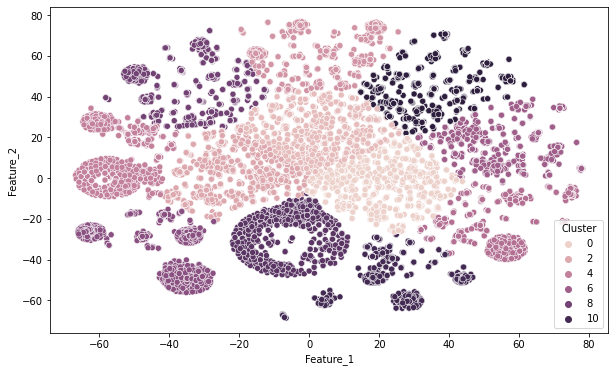

In [24]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

sns.scatterplot(data=df, x="Feature_1", y="Feature_2", hue="Cluster")
plt.savefig("Images/Clusters.png",  dpi=1200, bbox_inches='tight')
plt.show()